In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.ticker as mticker
import pylab as pl
import seaborn as sns
from tqdm.notebook import tqdm

# DATA PREP

In [245]:
def prep_data_SCF():
    '''
    Returns train energies array with STO3G first. 
    This has been the data structure in use since the first MFML model script and will now be considered the standard.
    '''
    molnames = ['urea','acrolein','alanine','sma','nitrophenol','urocanic','dmabn','thymine','o-hbdi']
    idx = np.arange(0,15000)
    idx = shuffle(idx,random_state=42)
    idx=idx[:3000]
    
    X=np.zeros((27000,253),dtype=float) #largest SLATM is for o-hbdi with 6438 features. Rest will be padded to this size.
    y_all = np.zeros((27000,5),dtype=float)
    
    start=0
    idx_names = np.zeros((27000),dtype=float)
    end = 3000
    for i,m in tqdm(enumerate(molnames),desc='building composite dataset of uncentered SCF'):
        names = np.full(3000,i)
        idx_names[start:end] = np.copy(names)
        temp_data=np.load(f'/home/vvinod/2024/MF24Dataset/dataset/CheMFi_{m}.npz')['SCF'] # in hE
        temp_X = np.load(f'/home/vvinod/2024/MF24Dataset/MFML/Reps/{m}_sortCM.npy')
        y_all[start:end,:] = temp_data[idx,:]
        X[start:end,:temp_X.shape[-1]] = temp_X[idx,:]
        #increment for next molecule
        start+= 3000
        end += 3000
    y_new = np.zeros((5),dtype=object)
    
    X,idx_names = shuffle(X,idx_names,random_state=42)
    y_train = np.zeros((5),dtype=object) #STO3G first
    for i in range(5):
        y_all[:,i] = shuffle(y_all[:,i],random_state=42)
        y_new[i] = y_all[:,i]
        y_train[i] = y_new[i][:23808]
    
    X_train = X[:23808,:]
    X_val = X[23808:24808,:]
    y_val = y_new[-1][23808:24808] #TZVP
    X_test = X[24808:,:]
    y_test = y_new[-1][24808:] #TZVP
    
    np.save('CheMFi/raws/X_train_sortCM.npy',X_train)
    np.save('CheMFi/raws/X_test_sortCM.npy',X_test)
    np.save('CheMFi/raws/X_val_sortCM.npy',X_val)
    np.save('CheMFi/raws/energies_SCF.npy',y_train,allow_pickle=True)
    np.save('CheMFi/raws/y_test_SCF.npy',y_test)
    np.save('CheMFi/raws/y_val_SCF.npy',y_val)
    
prep_data_SCF()

building composite dataset of uncentered SCF: 0it [00:00, ?it/s]

In [246]:
a = np.load('CheMFi/raws/X_test_sortCM.npy')
a.shape

(2192, 253)

In [5]:
def prep_data_EV():
    '''
    Returns train energies array with STO3G first. 
    This has been the data structure in use since the first MFML model script and will now be considered the standard.
    '''
    molnames = ['urea','acrolein','alanine','sma','nitrophenol','urocanic','dmabn','thymine','o-hbdi']
    idx = np.arange(0,15000)
    idx = shuffle(idx,random_state=42)
    idx=idx[:3000]
    
    X=np.zeros((27000,253),dtype=float) #largest CM is for o-hbdi with 253 features. Rest will be padded with 0 to this size.
    y_all = np.zeros((27000,5),dtype=float)
    
    start=0
    idx_names = np.zeros((27000),dtype=float)
    end = 3000
    for i,m in tqdm(enumerate(molnames),desc='building composite dataset of uncentered EV'):
        names = np.full(3000,i)
        idx_names[start:end] = np.copy(names)
        temp_data=np.load(f'/home/vvinod/2024/MF24Dataset/dataset/CheMFi_{m}.npz')['EV'][:,:,0]*0.00012 # in eV
        temp_X = np.load(f'/home/vvinod/2024/MF24Dataset/MFML/Reps/{m}_CM.npy')
        y_all[start:end,:] = temp_data[idx,:]
        X[start:end,:temp_X.shape[-1]] = temp_X[idx,:]
        #increment for next molecule
        start+= 3000
        end += 3000
    y_new = np.zeros((5),dtype=object)
    
    X,idx_names = shuffle(X,idx_names,random_state=42)
    y_train = np.zeros((5),dtype=object) #STO3G first
    for i in range(5):
        y_all[:,i] = shuffle(y_all[:,i],random_state=42)
        y_new[i] = y_all[:,i]
        y_train[i] = y_new[i][:23808]
    
    X_train = X[:23808,:]
    X_val = X[23808:24808,:]
    y_val = y_new[-1][23808:24808] #TZVP
    X_test = X[24808:,:]
    y_test = y_new[-1][24808:] #TZVP
    
    np.save('CheMFi/raws/X_train_CM.npy',X_train)
    np.save('CheMFi/raws/X_test_CM.npy',X_test)
    np.save('CheMFi/raws/X_val_CM.npy',X_val)
    np.save('CheMFi/raws/energies_EV.npy',y_train,allow_pickle=True)
    np.save('CheMFi/raws/y_test_EV.npy',y_test)
    np.save('CheMFi/raws/y_val_EV.npy',y_val)
prep_data_EV()

building composite dataset of uncentered EV: 0it [00:00, ?it/s]

In [7]:
def nestedindex():
    raw_index = np.arange(0,23808) #total size of multifidelity training set
    raw_index = np.vstack([raw_index,raw_index]).T
    indexes = np.zeros((5),dtype=object)
    for i in range(5):
        indexes[i] = np.copy(raw_index)
    np.save('CheMFi/raws/nested_indexes.npy',indexes,allow_pickle=True)
nestedindex()

In [8]:
#function to generate truly non-nested index
#samples used in one fidelity will not be present in another fidelity
def nonnestedindex():
    '''
    returns index file with STO3G indices as first entry of the object array
    '''
    raw_index = np.arange(0,23808) #total size of multifidelity training set
    raw_index = np.vstack([raw_index,raw_index]).T

    indexes = np.zeros((5),dtype=object)
    indexes[0] = np.copy(raw_index[:768,:])
    start = 768
    for i in range(1,5):
        end = start+int(1.5*2**(i+9))
        print(start,end)
        indexes[i] = np.copy(raw_index[start:end,:])
        start = end
    indexes = indexes[::-1]
    np.save('CheMFi/raws/indexes.npy',indexes,allow_pickle=True)
nonnestedindex()

768 2304
2304 5376
5376 11520
11520 23808


# PRELIM ANALYSIS

In [140]:
def prelim_analysis(data:np.ndarray,center:bool=False,units:str='hE',inset:bool=False):
    std = []
    diffs = []
    
    fids = ['STO3G','3-21G','6-31G','SVP','TZVP']
    colors = pl.cm.viridis(np.linspace(0,1,5))[::-1]
    
    fig,ax = plt.subplots(1,3,figsize=(12,4))
    if inset:
        axins1 = ax[2].inset_axes([0.5,0.15,0.3,0.3])
    fig.tight_layout(pad=3)
    
    for i in range(5):
        if center:
            data[i] = data[i]-np.mean(data[i])
        sns.kdeplot(ax=ax[0], data=data[i], 
                    common_norm=True, common_grid=True,
                    bw_method='scott', levels=10, thresh=0.05, 
                    gridsize=200, cut=3,
                    fill=False,bw_adjust=1,
                    cumulative=False,
                    label=fids[i],color=colors[i])
    ax[0].legend()
    #diff and std
    for i in range(4):
        diffs.append(
            np.mean(np.abs(data[i]-data[-1]))
        )
        std.append(
            np.std(np.abs(data[i]-data[-1]))
        )
        
        ax[2].scatter(data[i],data[-1],s=2,label=fids[i],color=colors[i])
        if inset:
            #,yticklabels=[-459,-457],xticklabels=[-450,-460])#,ylim=())#,)
            axins1.scatter(data[i],data[-1],s=2,color=colors[i])
            axins1.set_xlim(-460,-450)
            axins1.set_ylim(-457,-459)
            axins1.yaxis.set_label_position("right")
            axins1.yaxis.tick_right()
            ax[2].indicate_inset_zoom(axins1,edgecolor='gray')
        
    ax[2].plot([np.min(data[-1]),np.max(data[-1])],[np.min(data[-1]),np.max(data[-1])],linestyle='--',color='k')
    ax[0].ticklabel_format(axis='both',scilimits=[-1,1])
    ax[1].ticklabel_format(axis='y',scilimits=[0,0])
    ax[2].ticklabel_format(axis='both',scilimits=[-1,1])
        
    ax[1].errorbar(fids[:-1],diffs,std,color='k',ecolor='red',capsize=3,elinewidth=1,barsabove=True)
    ax[1].set_ylabel('$\Delta y_f^{TZVP}$'+f'[{units}]')
    
    ax[2].set_xlabel(r'$y^{f}$'+f'[{units}]')
    ax[2].set_ylabel(r'$y^{TZVP}$'+ f'[{units}]')
    ax[0].set_xlabel(r'$y^f$'+f'[{units}]')
    
    ax[0].set_title('Distribution',weight='bold')
    ax[1].set_title('Fidelity Difference',weight='bold')
    ax[2].set_title('Fidelity Scatter',weight='bold')
    ax[2].legend(markerscale=3)
    
    return fig,ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


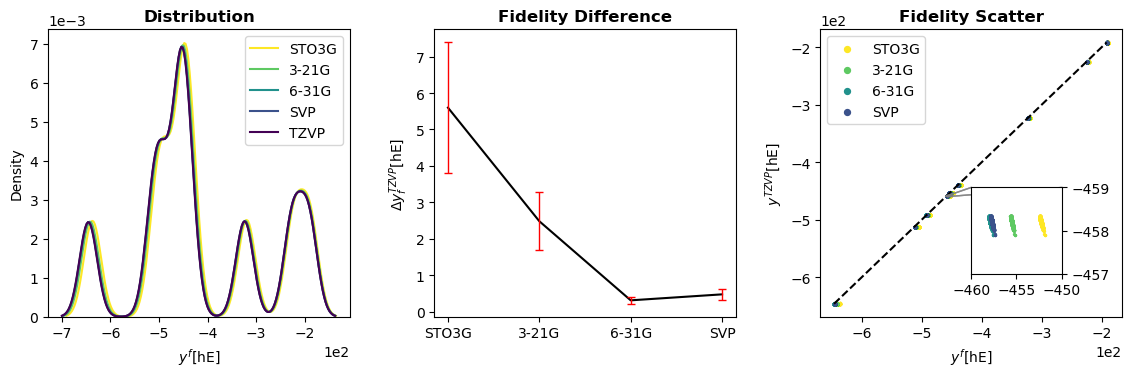

In [144]:
a = np.load('CheMFi/raws/energies_SCF.npy',allow_pickle=True)
fig,ax=prelim_analysis(data=a,center=False,units='hE',inset=True)
plt.savefig('CheMFi_SCF_prelims.eps',format='eps',bbox_inches='tight',dpi=150.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


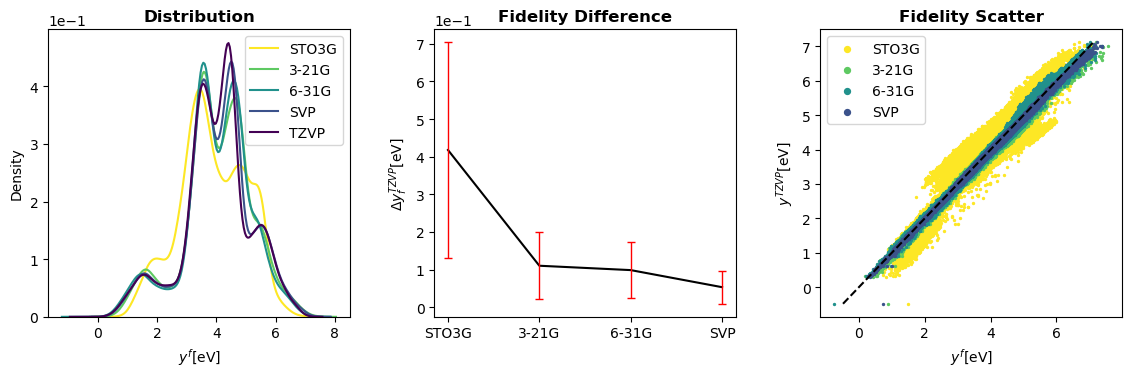

In [145]:
a = np.load('CheMFi/raws/energies_EV.npy',allow_pickle=True)
fig,ax=prelim_analysis(data=a,center=False,units='eV')
plt.savefig('CheMFi_EV_prelims.eps',format='eps',bbox_inches='tight',dpi=150.0)

# LCs

SCF [hE]
KRR:  0.049
Nested - Default:  0.01 ; OLS:  0.01
Non-nested - Default:  0.057 ; OLS:  0.015


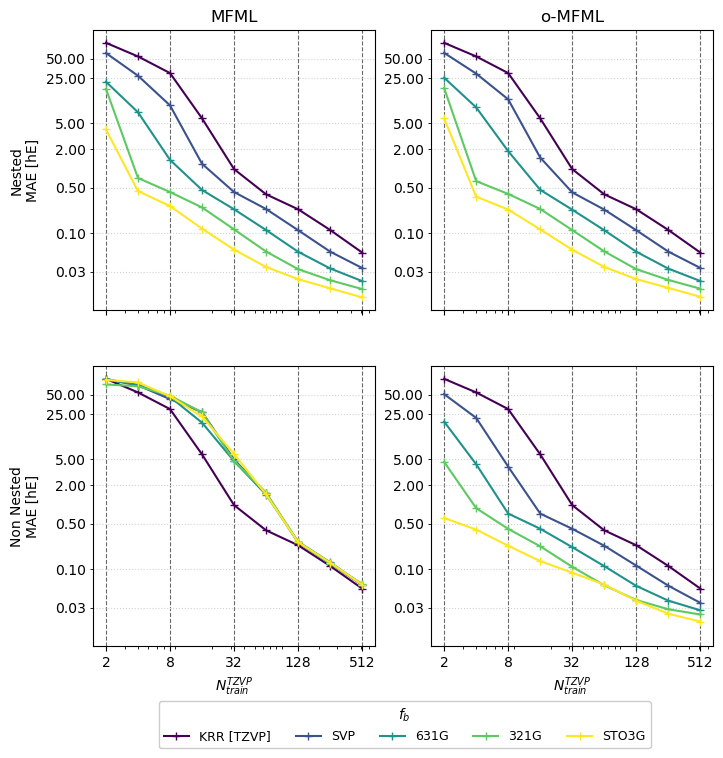

In [184]:
def nestplots_SCF():
    n = 2**np.arange(1,10)
    mae_def = np.load('CheMFi/outs/TrueNonNestedSamedefallMAEs_SCF_CM.npy',allow_pickle=True)
    mae_OLS = np.load('CheMFi/outs/TrueNonNestedSameOLSallMAEs_SCF_CM.npy',allow_pickle=True)
    #fully nested
    nested_def = np.load('CheMFi/outs/NestedSamedefallMAEs_SCF_CM.npy',allow_pickle=True)
    nested_OLS = np.load('CheMFi/outs/NestedSameOLSallMAEs_SCF_CM.npy',allow_pickle=True)
    fids = ['STO3G','321G','631G','SVP']
    markers = ['^','*','P','d']
    colors = pl.cm.viridis(np.linspace(0,1,5))
    
    print('SCF [hE]\nKRR: ',np.round(mae_def[0][-1],3))
    print('Nested - Default: ',np.round(nested_def[1][-1],3),'; OLS: ',np.round(nested_OLS[1][-1],3))
    print('Non-nested - Default: ',np.round(mae_def[1][-1],3),'; OLS: ',np.round(mae_OLS[1][-1],3))
    
    fig,ax = plt.subplots(2,2,figsize=(8,8),sharey=True, sharex=True)
    ax = ax.flatten('C')
    ax[0].loglog(n,nested_def[0],marker='+',label='KRR [TZVP]',color=colors[0])
    ax[1].loglog(n,nested_def[0],marker='+',label='KRR [TZVP]',color=colors[0])
    ax[2].loglog(n,mae_def[0],marker='+',label='KRR [TZVP]',color=colors[0])
    ax[3].loglog(n,mae_def[0],marker='+',label='KRR [TZVP]',color=colors[0])

    ax[0].set_title('MFML')
    ax[1].set_title('o-MFML')
    ax[0].set_ylabel('Nested\nMAE [hE]')
    ax[2].set_ylabel('Non Nested\nMAE [hE]')

    for i in range(3,-1,-1):
        ax[0].loglog(n,nested_def[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
        ax[1].loglog(n,nested_OLS[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
        ax[2].loglog(n,mae_def[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
        ax[3].loglog(n,mae_OLS[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
    ax[2].legend(fontsize=9,framealpha=1.0,frameon=True,title='$f_b$',ncol=5,bbox_to_anchor=(2,-0.175))
    ax[2].set_xlabel('$N_{train}^{TZVP}$')
    ax[3].set_xlabel('$N_{train}^{TZVP}$')
    #cosmetics
    y_minor = mticker.LogLocator(base = 2,subs=[5,15,50],numticks=8)#np.arange(1.0,5,2), numticks = 5)
    y_major = mticker.LogLocator(base = 10,subs=[1,10,100],numticks=3)#np.arange(1.0,8,4), numticks = 10)
    for i in range(4):
        ax[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_minor_locator(y_minor)
        ax[i].yaxis.set_major_locator(y_major)
        ax[i].set_yticks([0.025,0.1,0.5,2,5,25,50],minor=True)
        ax[i].grid(True, which="major", ls="--",color='dimgray')
        ax[i].grid(True, axis='y', which="minor", ls=":",color='lightgray')
        ax[i].yaxis.set_tick_params(labelleft=True,which='both')
        ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter(None))
        ax[i].set_xticks([2,8,32,128,512])
        
nestplots_SCF()
plt.savefig('CheMFi_LCs_SCF.eps',format='eps',bbox_inches='tight',dpi=150)

Excitation Energy [eV]
KRR:  0.161
Nested - Default:  0.078 ; OLS:  0.077
Non-nested - Default:  0.23 ; OLS:  0.106


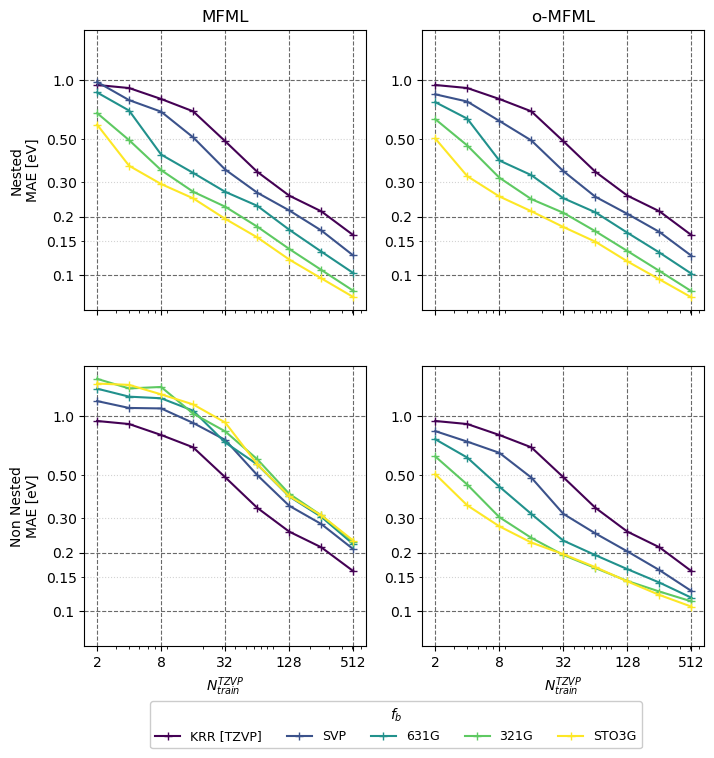

In [225]:
def nestplots_EV():
    n = 2**np.arange(1,10)
    mae_def = np.load('CheMFi/outs/TrueNonNestedSamedefallMAEs_EV.npy',allow_pickle=True)
    mae_OLS = np.load('CheMFi/outs/TrueNonNestedSameOLSallMAEs_EV.npy',allow_pickle=True)
    #fully nested
    nested_def = np.load('CheMFi/outs/NestedSamedefallMAEs_EV.npy',allow_pickle=True)
    nested_OLS = np.load('CheMFi/outs/NestedSameOLSallMAEs_EV.npy',allow_pickle=True)
    fids = ['STO3G','321G','631G','SVP']
    markers = ['^','*','P','d']
    colors = pl.cm.viridis(np.linspace(0,1,5))
    
    print('Excitation Energy [eV]')
    print('KRR: ',np.round(mae_def[0][-1],3))
    print('Nested - Default: ',np.round(nested_def[1][-1],3),'; OLS: ',np.round(nested_OLS[1][-1],3))
    print('Non-nested - Default: ',np.round(mae_def[1][-1],3),'; OLS: ',np.round(mae_OLS[1][-1],3))
    
    fig,ax = plt.subplots(2,2,figsize=(8,8),sharey=True, sharex=True)
    ax = ax.flatten('C')
    ax[0].loglog(n,nested_def[0],marker='+',label='KRR [TZVP]',color=colors[0])
    ax[1].loglog(n,nested_def[0],marker='+',label='KRR [TZVP]',color=colors[0])
    ax[2].loglog(n,mae_def[0],marker='+',label='KRR [TZVP]',color=colors[0])
    ax[3].loglog(n,mae_def[0],marker='+',label='KRR [TZVP]',color=colors[0])

    ax[0].set_title('MFML')
    ax[1].set_title('o-MFML')
    ax[0].set_ylabel('Nested\nMAE [eV]')
    ax[2].set_ylabel('Non Nested\nMAE [eV]')

    for i in range(3,-1,-1):
        ax[0].loglog(n,nested_def[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
        ax[1].loglog(n,nested_OLS[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
        ax[2].loglog(n,mae_def[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
        ax[3].loglog(n,mae_OLS[i+1],marker='+',label=fids[i],linestyle='-',color=colors[4-i])
    ax[2].legend(fontsize=9,framealpha=1.0,frameon=True,title='$f_b$',ncol=5,bbox_to_anchor=(2,-0.175))
    ax[2].set_xlabel('$N_{train}^{TZVP}$')
    ax[3].set_xlabel('$N_{train}^{TZVP}$')
    #cosmetics
    y_minor = mticker.LogLocator(base = 2,subs=np.arange(0,2,5), numticks = 5)
    y_major = mticker.LogLocator(base = 10,subs=np.linspace(0,2,3), numticks = 10)
    for i in range(4):
        ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter(None))
        ax[i].set_xticks([2,8,32,128,512])
        ax[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_minor_locator(y_minor)
        ax[i].yaxis.set_major_locator(y_major)
        ax[i].grid(True, which="major", ls="--",color='dimgray')
        ax[i].grid(True, axis='y', which="minor", ls=":",color='lightgray')
        ax[i].yaxis.set_tick_params(labelleft=True,which='both')
        ax[i].set_yticks([0.1,0.15,0.2,0.3,0.5,1.0],minor=True)
        

    #fig.suptitle('Learning Curves (first excited state)')
nestplots_EV()
plt.savefig('CheMFi_LCs_EV.eps',format='eps',bbox_inches='tight',dpi=150)

In [248]:
sortcmols_SCF = np.load('CheMFi/outs/sf_SCF_sortCM.npy',allow_pickle=True)

In [250]:
sortcmols_SCF.shape

(9,)

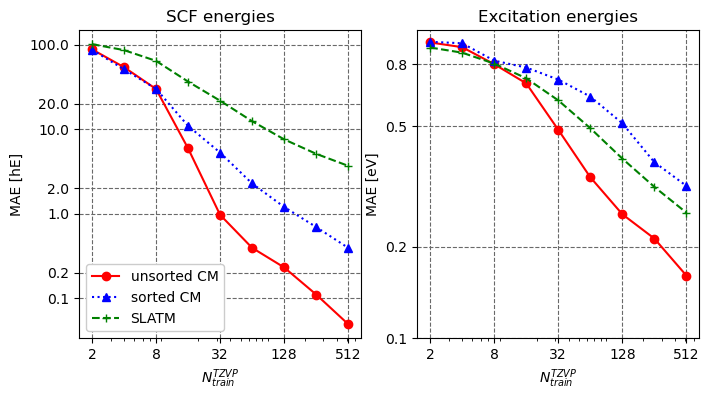

In [260]:
def single_fid_repComp():
    fig,ax = plt.subplots(1,2,figsize=(8,4),sharey=False)
    n = 2**np.arange(1,10)
    fids = ['STO3G','321G','631G','SVP']
    
    cmols_SCF = np.load('CheMFi/outs/NestedSameOLSallMAEs_SCF_CM.npy',allow_pickle=True)
    sortcmols_SCF = np.load('CheMFi/outs/sf_SCF_sortCM.npy',allow_pickle=True)
    slatmols_SCF = np.load('CheMFi/outs/NestedSameOLSallMAEs_SCF.npy',allow_pickle=True)
    
    cmols_EV = np.load('CheMFi/outs/NestedSameOLSallMAEs_EV.npy',allow_pickle=True)
    sortcmols_EV = np.load('CheMFi/outs/sf_EV_sortCM.npy',allow_pickle=True)
    slatmols_EV = np.load('CheMFi/outs/NestedSameOLSallMAEs_EV_SLATM.npy',allow_pickle=True)
    
    ax[0].loglog(n,cmols_SCF[0],marker='o',color='red',label='unsorted CM')
    ax[0].loglog(n,sortcmols_SCF,marker='^',color='blue',label='sorted CM',linestyle=':')
    ax[0].loglog(n,slatmols_SCF[0],marker='+',color='green',label='SLATM',linestyle='--')
    
    ax[0].set_ylabel('MAE [hE]')
    ax[0].legend(loc='lower left',frameon=True,framealpha=1.0)
    ax[0].set_xlabel('$N_{train}^{TZVP}$')
    ax[0].tick_params(axis='y')
    
    y_minor = mticker.LogLocator(base = 2,subs=np.arange(0,2,5), numticks = 5)
    y_major = mticker.LogLocator(base = 10,subs=np.linspace(0,2,3), numticks = 10)
    ax[0].xaxis.set_major_formatter(mticker.ScalarFormatter(None))
    ax[0].yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax[0].yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[0].yaxis.set_minor_locator(y_minor)
    ax[0].yaxis.set_major_locator(y_major)
    ax[0].grid(True, which="major", ls="--",color='dimgray')
    ax[0].grid(True, axis='y', which="minor", ls=":",color='gray')
    ax[0].yaxis.set_tick_params(labelleft=True,which='both')
    #ax[0].set_yticks([0.04,0.5,2,20,50,100],minor=False)
    ax[0].set_xticks([2,8,32,128,512])
    
    ax[1].tick_params(axis='y')
    ax[1].loglog(n,cmols_EV[0],marker='o',color='red',label='unsorted CM')
    ax[1].loglog(n,sortcmols_EV,marker='^',color='blue',label='sorted CM',linestyle=':')
    ax[1].loglog(n,slatmols_EV[0],marker='+',color='green',label='SLATM',linestyle='--')
    ax[1].yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax[1].xaxis.set_major_formatter(mticker.ScalarFormatter(None))
    ax[1].yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[1].yaxis.set_minor_locator(y_minor)
    ax[1].yaxis.set_major_locator(y_major)
    ax[1].grid(True, which="major", ls="--",color='dimgray')
    ax[1].grid(True, axis='y', which="minor", ls=":",color='gray')
    #ax[1].yaxis.set_tick_params(labelleft=True,which='both')
    ax[1].set_yticks([0.1,0.2 ,0.5,0.8],minor=False)
    ax[1].set_ylabel('MAE [eV]')
    ax[1].set_xticks([2,8,32,128,512])
    
    ax[1].set_xlabel('$N_{train}^{TZVP}$')
    ax[1].tick_params(axis='y')
    
    ax[0].set_title('SCF energies')
    ax[1].set_title('Excitation energies')
    
single_fid_repComp()
plt.savefig('plots/sfRepComparison.png',dpi=150,format='png',bbox_inches='tight')

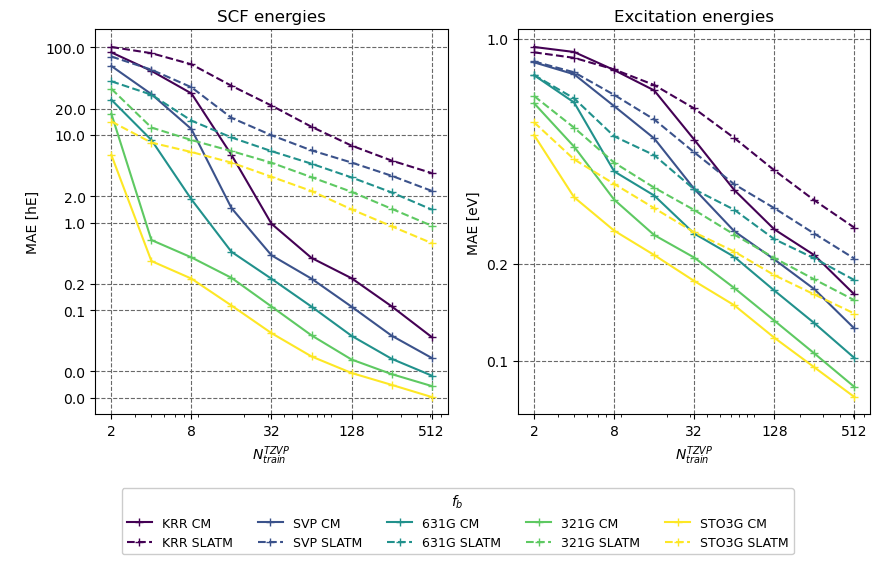

In [188]:
def rep_comparison_plots():
    fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=False)
    ax[0].set_title('SCF energies')
    ax[1].set_title('Excitation energies')
    n = 2**np.arange(1,10)
    fids = ['STO3G','321G','631G','SVP']
    colors = pl.cm.viridis(np.linspace(0,1,5))
    
    cmols_SCF = np.load('CheMFi/outs/NestedSameOLSallMAEs_SCF_CM.npy',allow_pickle=True)
    slatmols_SCF = np.load('CheMFi/outs/NestedSameOLSallMAEs_SCF.npy',allow_pickle=True)
    cmols_EV = np.load('CheMFi/outs/NestedSameOLSallMAEs_EV.npy',allow_pickle=True)
    slatmols_EV = np.load('CheMFi/outs/NestedSameOLSallMAEs_EV_SLATM.npy',allow_pickle=True)
    
    ax[0].loglog(n,cmols_SCF[0],marker='+',color=colors[0],label='KRR CM')
    ax[0].loglog(n,slatmols_SCF[0],marker='+',color=colors[0],label='KRR SLATM',linestyle='--')
    ax[1].loglog(n,cmols_EV[0],marker='+',color=colors[0],label='KRR CM')
    ax[1].loglog(n,slatmols_EV[0],marker='+',color=colors[0],label='KRR SLATM',linestyle='--')
    
    ax[0].set_ylabel('\nMAE [hE]')
    ax[1].set_ylabel('\nMAE [eV]')
    for i in range(3,-1,-1):
        ax[0].loglog(n,cmols_SCF[i+1],marker='+',label=fids[i]+' CM',linestyle='-',color=colors[4-i])
        ax[0].loglog(n,slatmols_SCF[i+1],marker='+',label=fids[i]+' SLATM',linestyle='--',color=colors[4-i])
        
        ax[1].loglog(n,cmols_EV[i+1],marker='+',label=fids[i]+' CM',linestyle='-',color=colors[4-i])
        ax[1].loglog(n,slatmols_EV[i+1],marker='+',label=fids[i]+' SLATM',linestyle='--',color=colors[4-i])
    
    ax[0].legend(fontsize=9,framealpha=1.0,frameon=True,title='$f_b$',ncol=5,bbox_to_anchor=(2,-0.175))
    ax[0].set_xlabel('$N_{train}^{TZVP}$')
    ax[1].set_xlabel('$N_{train}^{TZVP}$')
    #cosmetics
    y_minor = mticker.LogLocator(base = 2,subs=np.arange(0,2,5), numticks = 5)
    y_major = mticker.LogLocator(base = 10,subs=np.linspace(0,2,3), numticks = 10)
    for i in range(2):
        ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter(None))
        ax[i].set_xticks([2,8,32,128,512])
        ax[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_minor_locator(y_minor)
        ax[i].yaxis.set_major_locator(y_major)
        ax[i].grid(True, which="major", ls="--",color='dimgray')
        ax[i].grid(True, axis='y', which="minor", ls=":",color='lightgray')
        ax[i].yaxis.set_tick_params(labelleft=True,which='both')
rep_comparison_plots()
plt.savefig('plots/RepComparison.eps',dpi=150,format='eps',bbox_inches='tight')

CM better than SLATM for EV nested and non-nested


# COEFFS

In [146]:
def coeff_subspace(OLScoef, ax = None, right=True, m=40,f='{:.3E}'):
    nfids=5
    ax = ax or plt.gca()
    plt.tight_layout()
    labels = np.asarray(['STO-3G','3-21G',
                         '6-31G','SVP','TZVP'])
    
    colors = pl.cm.jet(np.linspace(0,1,9))
    
    
    count_arr = np.asarray([0,0,1,1,2,2,3,3,4])
    ind_arr = np.asarray([13,12,12,11,11,10,10,9,9])
    
    count1 = 0
    for i in range(nfids-1,-1,-1):
        
        ax.plot([i+1+8],[labels[count1]],marker='s',color=colors[8-i],markersize=m,linestyle='',fillstyle='none',markeredgewidth=m/15)
        if i>0:
            ax.plot([i+8],[labels[count1]],marker='s',color=colors[7-i],markersize=m,linestyle='',fillstyle='none',markeredgewidth=m/15)
            
        count1 += 1
    ax.set_ylim(-0.5,4.5)
    ax.set_xlim(8.5,13.5)
    ax.set_xlabel('$\log_2(N_{\mathrm{train}})$')
    ax.tick_params(axis='both', which='major')
    ax.grid(True, which="major", ls="--",color='silver')
    if right:
        ax.yaxis.tick_right()
    
    #placing the coeffs as text
    col_arr = np.full(9,'k')#['k','k','w','w','w','k','k','w','w']
    for i in range(5):
        ax.text(x=12.78-i,y=labels[i],s=f.format(OLScoef[i]),color='k',weight='bold')
        try:
            ax.text(x=11.78-i,y=labels[i],s=f.format(OLScoef[5+i]),color='k',weight='bold')
        except:
            pass

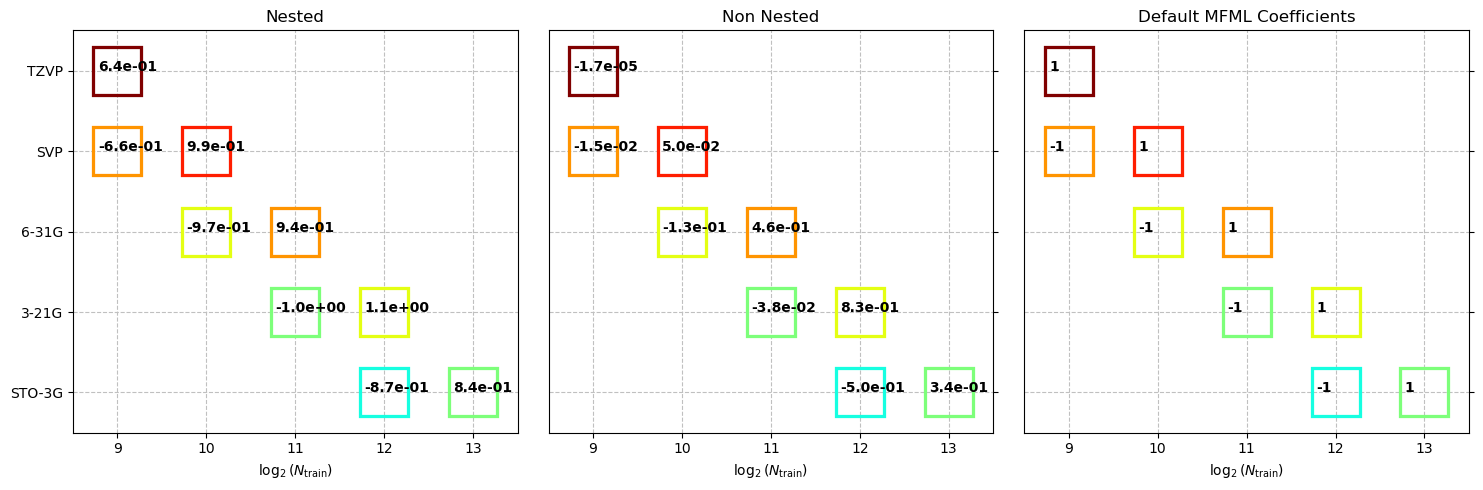

In [186]:
def coeff_plots_SCF():
    nonested = np.load('CheMFi/outs/CoeffsNonNestSameOLS_SCF_CM.npy')
    nested = np.load('CheMFi/outs/CoeffsNestSameOLS_SCF_CM.npy')
    fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
    #nested
    coeff_subspace(OLScoef=nested,ax=ax[0],m=35,f='{:.1e}',right=False)
    #nonnested
    coeff_subspace(OLScoef=nonested,ax=ax[1],m=35,f='{:.1e}')
    ax[0].set_title('Nested')
    ax[1].set_title('Non Nested')
    ax[2].set_title('Default MFML Coefficients')
    defcoeff=np.asarray([1,1,1,1,1,-1,-1,-1,-1])
    coeff_subspace(OLScoef=defcoeff,ax=ax[-1],m=35,f='{}')
    
coeff_plots_SCF()
plt.savefig('CheMFiCoeffs_SCF.eps',format='eps',bbox_inches='tight',dpi=150)

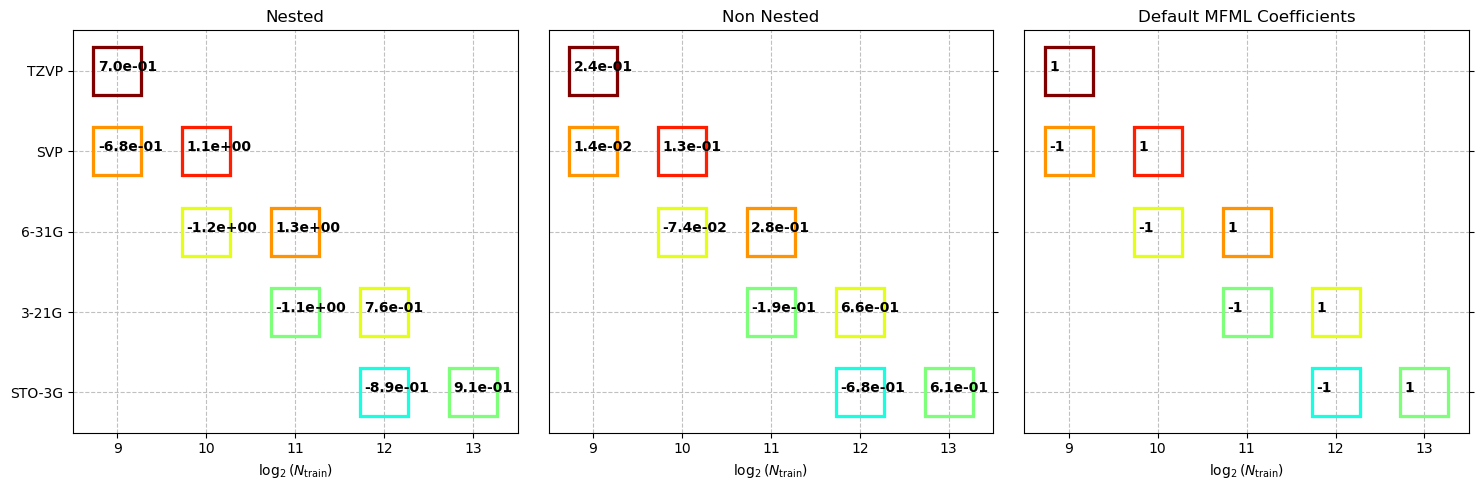

In [147]:
def coeff_plots_EV():
    nonested = np.load('CheMFi/outs/CoeffsNonNestSameOLS_EV.npy')
    nested = np.load('CheMFi/outs/CoeffsNestSameOLS_EV.npy')
    fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
    #nested
    coeff_subspace(OLScoef=nested,ax=ax[0],m=35,f='{:.1e}',right=False)
    #nonnested
    coeff_subspace(OLScoef=nonested,ax=ax[1],m=35,f='{:.1e}')
    ax[0].set_title('Nested')
    ax[1].set_title('Non Nested')
    ax[2].set_title('Default MFML Coefficients')
    defcoeff=np.asarray([1,1,1,1,1,-1,-1,-1,-1])
    coeff_subspace(OLScoef=defcoeff,ax=ax[-1],m=35,f='{}')
    
coeff_plots_EV()
plt.savefig('CheMFiCoeffs_EV.png',format='png',bbox_inches='tight',dpi=150)